In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, Flatten, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [ ]:
df = pd.read_csv("/content/archive (2).zip")
df.head()


,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [ ]:
df["passed"] = (df["exam_score"] >= 50).astype(int)
df["passed"].value_counts()



,count
passed,
1,14596
0,5404


In [ ]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)


/tmp/ipython-input-3860149331.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3860149331.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:
df["study_efficiency"] = df["study_hours"] / df["sleep_hours"]


In [ ]:
X = df.drop(columns=["exam_score", "passed", "student_id"])
y = df["passed"]


In [ ]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])


In [ ]:
Q1 = df["study_efficiency"].quantile(0.25)
Q3 = df["study_efficiency"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[
    (df["study_efficiency"] < lower_bound) |
    (df["study_efficiency"] > upper_bound)
]

print(f"Outlierek száma: {len(outliers)}")


Outlierek száma: 133


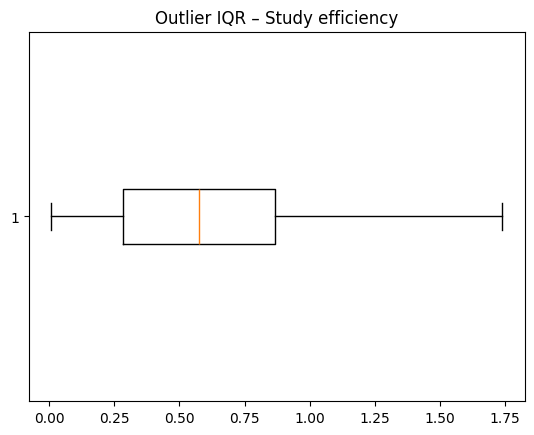

In [ ]:
plt.figure()
plt.boxplot(df["study_efficiency"], vert=False)
plt.title("Outlier IQR – Study ")
plt.show()


In [ ]:
df["study_efficiency"] = np.clip(
    df["study_efficiency"],
    lower_bound,
    upper_bound
)


In [ ]:
categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(exclude="object").columns

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le


In [ ]:
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
model_inputs = []
encoded_features = []

for feature in categorical_cols:
    feature_input = Input(shape=(1,), name=f"{feature}_input")

    feature_embedding = Embedding(
        input_dim=X[feature].nunique() + 1,
        output_dim=4,
        name=f"{feature}_embedding"
    )(feature_input)

    feature_embedding = Flatten()(feature_embedding)

    model_inputs.append(feature_input)
    encoded_features.append(feature_embedding)

numerical_input = Input(
    shape=(len(numerical_cols),),
    name="numerical_input"
)

model_inputs.append(numerical_input)
encoded_features.append(numerical_input)

merged_features = Concatenate(name="feature_concatenation")(encoded_features)

hidden = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(merged_features)
hidden = Dropout(0.3)(hidden)
hidden = Dense(64, activation="relu")(hidden)
hidden = Dense(64, activation="relu")(hidden)
hidden = Dense(32, activation="relu")(hidden)
hidden = Dense(16, activation="relu")(hidden)

output = Dense(1, activation="sigmoid", name="output_layer")(hidden)

model = Model(inputs=model_inputs, outputs=output)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    [X_train[col] for col in categorical_cols] + [X_train[numerical_cols]],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8125 - loss: 0.4288 - val_accuracy: 0.8591 - val_loss: 0.3223
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8593 - loss: 0.3208 - val_accuracy: 0.8597 - val_loss: 0.3167
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8684 - loss: 0.3058 - val_accuracy: 0.8594 - val_loss: 0.3164
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8608 - loss: 0.3200 - val_accuracy: 0.8594 - val_loss: 0.3144
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8686 - loss: 0.3008 - val_accuracy: 0.8569 - val_loss: 0.3131
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8663 - loss: 0.3043 - val_accuracy: 0.8628 - val_loss: 0.3214
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8687 - loss: 0.3007 - val_accuracy: 0.8603 - val_loss: 0.3140
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8675 - loss: 0.3004 - val_accuracy: 0.

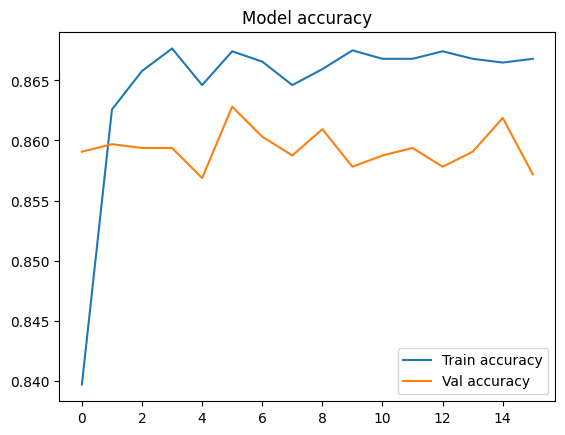

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
plt.legend()
plt.title("Model accuracy")
plt.show()


In [ ]:
y_pred = model.predict(
    [X_test[col] for col in categorical_cols] + [X_test[numerical_cols]]
)
y_pred = (y_pred > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"Modell pontossága a teszt adathalmazon: {acc*100:.2f}%\n")

cm = confusion_matrix(y_test, y_pred)

print("Zavaró mátrix (Confusion Matrix):")
print(f"           Predikált Nem ment át | Predikált Átment")
print(f"Valós Nem ment át     {cm[0,0]}        | {cm[0,1]}")
print(f"Valós Átment          {cm[1,0]}        | {cm[1,1]}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Modell pontossága a teszt adathalmazon: 86.67%

Zavaró mátrix (Confusion Matrix):
           Predikált Nem ment át | Predikált Átment
Valós Nem ment át     790        | 294
Valós Átment          239        | 2677
